# Annotation Distances in Common Datasets

This notebook creates a distribution over the distances of common datasets.

Annotations for ArgoVerse:

In [2]:
import pyarrow.feather as feather
from glob import glob
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

from typing import List
import os
from scipy.spatial.transform import Rotation

from collections import defaultdict

Calculating distances


  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [00:08<00:00, 81.48it/s]


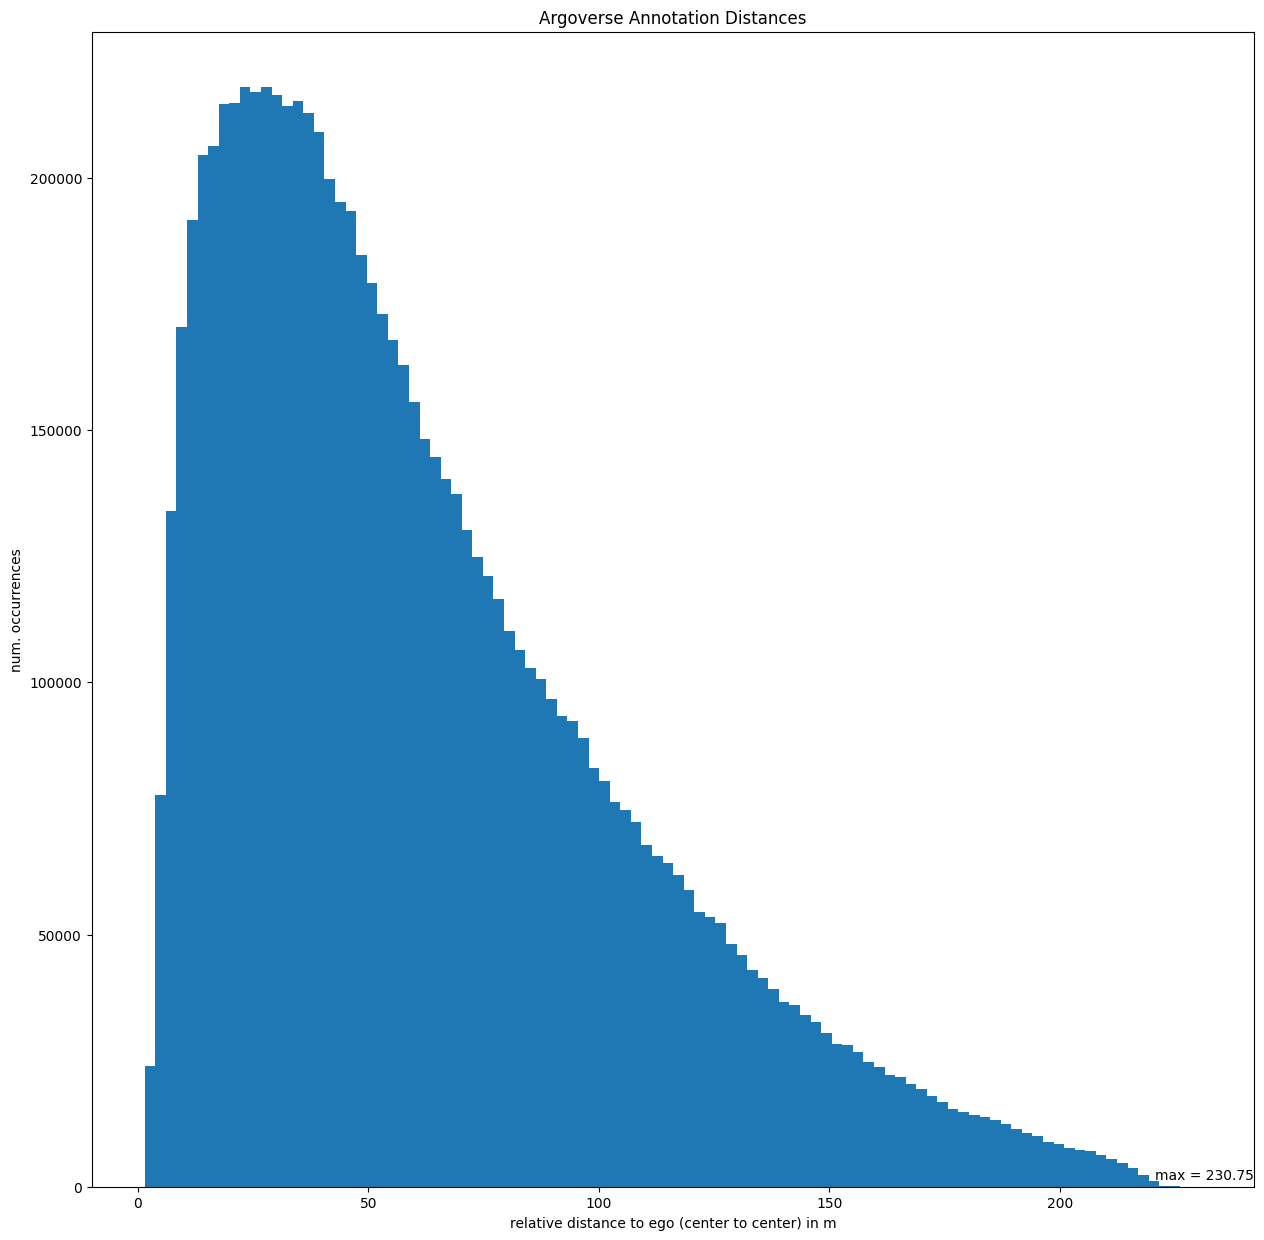

In [3]:
ARGOVERSE_DATA_PATH = "/home/evgeny/range_of_experts/mmdetection3d/data/argoverse/train"

print("Calculating distances")
argoverse_distances = list()
for file in tqdm(glob(ARGOVERSE_DATA_PATH + '/*')):
    with open(os.path.join(file, 'annotations.feather'), 'rb') as f:
        read_df = feather.read_feather(f)
        argoverse_distances.append(np.linalg.norm(np.array(read_df[['tx_m', 'ty_m', 'tz_m']]), axis=1))

argoverse_distances = np.concatenate(argoverse_distances)

fig = plt.figure(figsize=(15,15))
plt.title('Argoverse Annotation Distances')
plt.xlabel('relative distance to ego (center to center) in m')
plt.ylabel('num. occurrences')
plt.text(max(argoverse_distances) - 10, 1400, f'max = {max(argoverse_distances):.2f}')

plt.hist(argoverse_distances,bins=100)
plt.savefig('argoverse_distances.png')

Create NuScenes Distance plots

In [4]:
NUSCENES_DATA_PATH = "/home/evgeny/range_of_experts/mmdetection3d/data/nuscenes/v1.0-trainval"

sample_annotation = json.load(open(f"{NUSCENES_DATA_PATH}/sample_annotation.json"))
ego_pose = json.load(open(f"{NUSCENES_DATA_PATH}/ego_pose.json"))
sample = json.load(open(f"{NUSCENES_DATA_PATH}/sample.json"))
sample_data = json.load(open(f"{NUSCENES_DATA_PATH}/sample_data.json"))

Create some utility Classes

In [5]:
class Annotation:
    def __init__(self, ann: dict) -> None:
        self.size = np.array(ann["size"])
        self.translation = np.array(ann["translation"])
        self.rotation = Rotation.from_rotvec(
            Rotation.from_quat(ann["rotation"]).as_rotvec()
            # - np.array([0, 0, np.pi / 2])
        )
        self.num_lidar_pts = ann["num_lidar_pts"]

    def bounding_box(self):
        return self.rotation.apply(
            np.array(
                [
                    [-self.size[0] / 2, -self.size[1] / 2, -self.size[2] / 2],
                    [-self.size[0] / 2, -self.size[1] / 2,  self.size[2] / 2],
                    [-self.size[0] / 2,  self.size[1] / 2, -self.size[2] / 2],
                    [-self.size[0] / 2,  self.size[1] / 2,  self.size[2] / 2],
                    [ self.size[0] / 2, -self.size[1] / 2, -self.size[2] / 2],
                    [ self.size[0] / 2, -self.size[1] / 2,  self.size[2] / 2],
                    [ self.size[0] / 2,  self.size[1] / 2, -self.size[2] / 2],
                    [ self.size[0] / 2,  self.size[1] / 2,  self.size[2] / 2],
                ]
            )
        ) + self.translation


class Ego:
    def __init__(self, ann: dict) -> None:
        self.translation = np.array(ann["translation"])
        self.rotation = Rotation.from_quat(ann["rotation"])


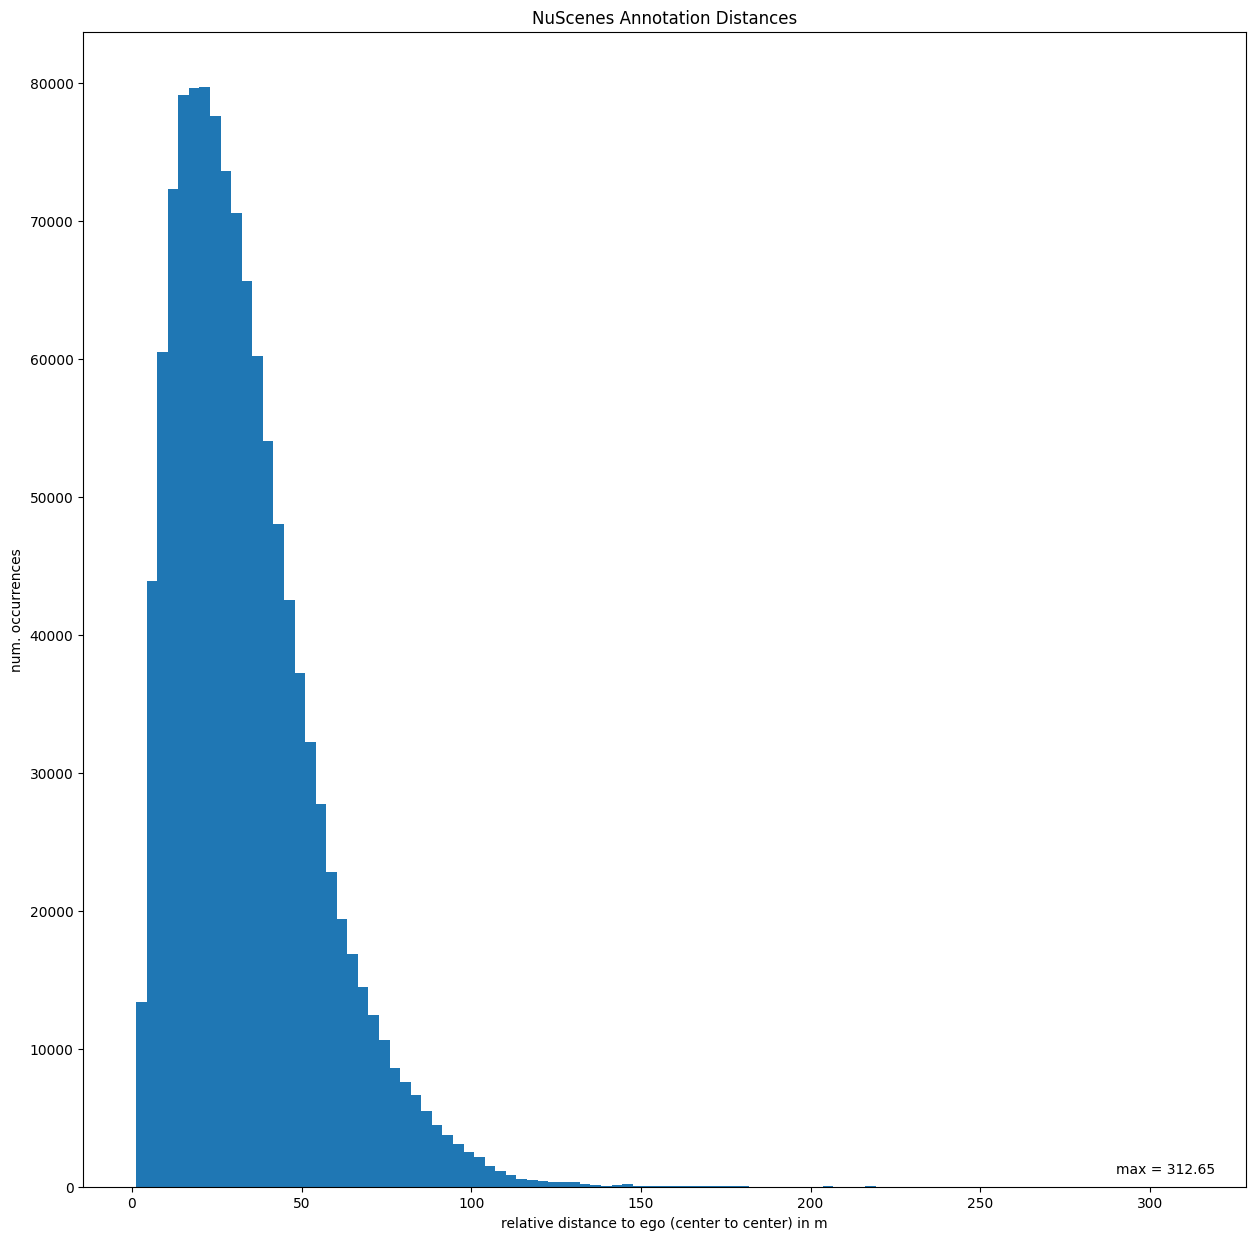

In [6]:
# all values as dict with sample as key
sample_dict = {s['token']: s for s in sample}

ego_pose_dict = dict()
for s in ego_pose:
    ego_pose_dict[s['token']] = s


sample_data_dict = dict()
for s in sample_data:
    if 'LIDAR' in s['filename']:
        sample_data_dict[s['sample_token']] = {**s, **{'ego_pose': ego_pose_dict[s['ego_pose_token']]}}

sample_annotation_dict = defaultdict(list)
for s in sample_annotation:
    sample_annotation_dict[s['sample_token']].append(s)
sample_annotation_dict = dict(sample_annotation_dict)


nuscenes_sample_data = list()
for s in sample_dict.keys():
    nuscenes_sample_data.append(
        {
            'sample': sample_dict[s],
            'sample_data': sample_data_dict[s],
            'ego_pose': Ego(sample_data_dict[s]['ego_pose']),
            'sample_annotation': [Annotation(sa) for sa in sample_annotation_dict.get(s, list())]
        }
    )

nuscenes_distances = list()
for s in nuscenes_sample_data:
    nuscenes_distances += [np.linalg.norm(sa.translation - s['ego_pose'].translation) for sa in s['sample_annotation']]


fig = plt.figure(figsize=(15,15))

plt.title('NuScenes Annotation Distances')
plt.xlabel('relative distance to ego (center to center) in m')
plt.ylabel('num. occurrences')
plt.text(290, 1000, f'max = {max(nuscenes_distances):.2f}')
plt.hist(nuscenes_distances,bins=100)
plt.savefig('nuscenes_distances.png')

Create KITTI plot

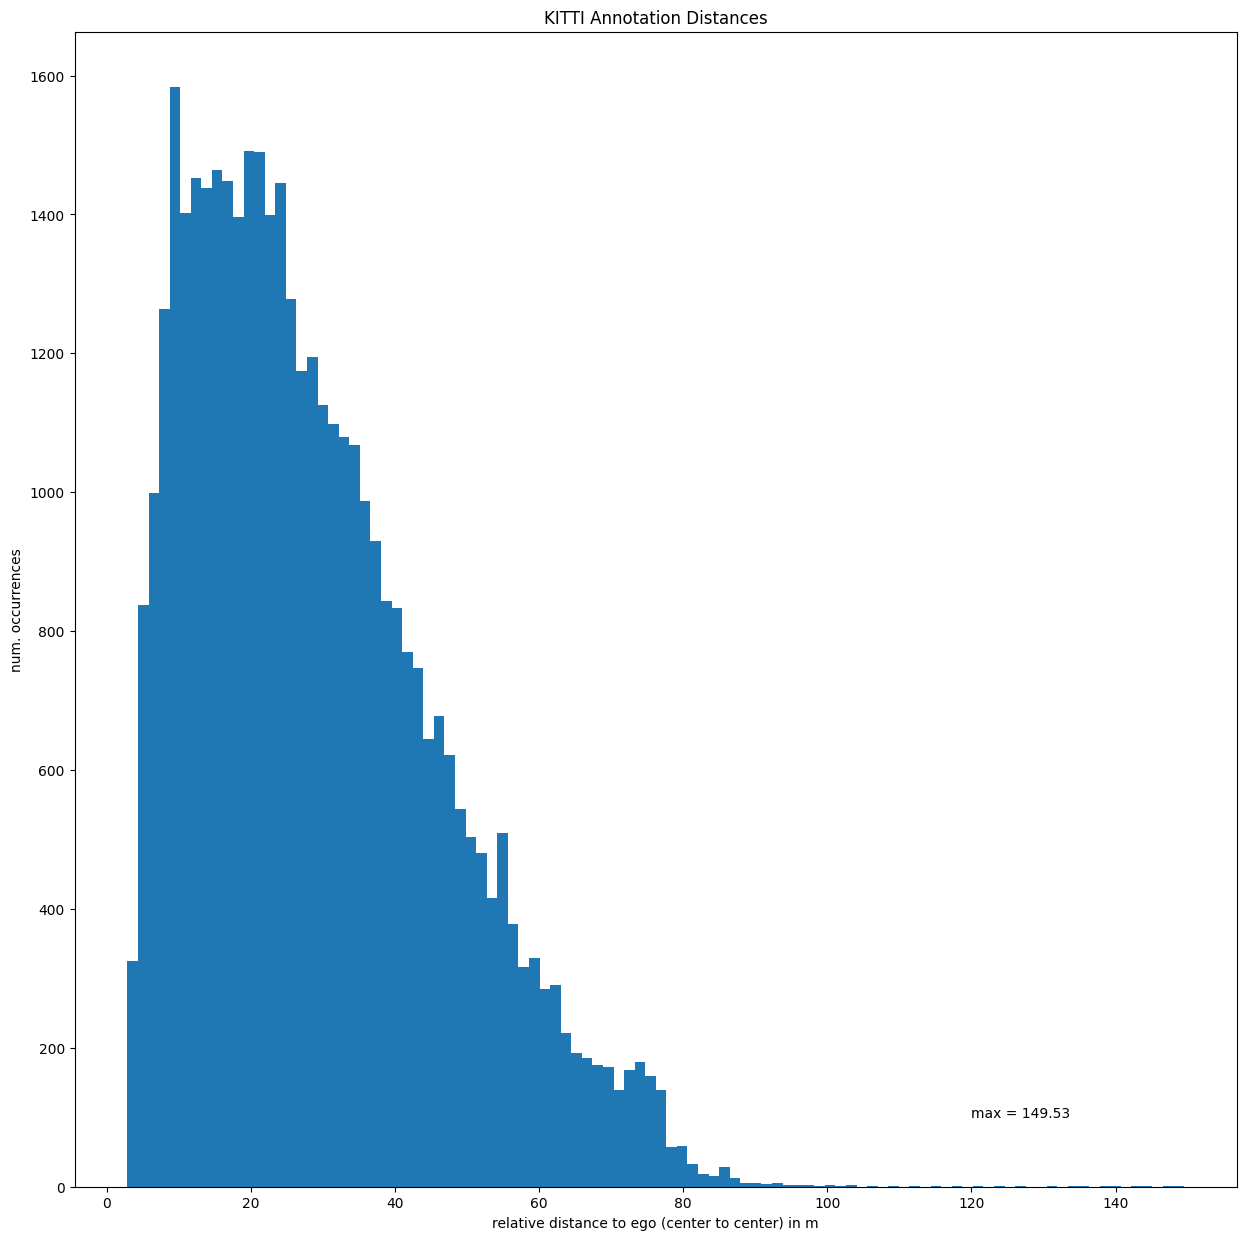

In [7]:
KITTI_DATA_PATH = '/home/evgeny/range_of_experts/mmdetection3d/data/kitti/training/label_2'

def get_label_anno(label_path):
    '''
        from: https://github.com/open-mmlab/mmdetection3d/blob/a8817998d4f36f4f2f178b055af6a0ded1b14a81/tools/data_converter/kitti_data_utils.py#L105
    '''
    annotations = {}
    annotations.update({
        'name': [],
        'truncated': [],
        'occluded': [],
        'alpha': [],
        'bbox': [],
        'dimensions': [],
        'location': [],
        'rotation_y': []
    })
    with open(label_path, 'r') as f:
        lines = f.readlines()
    # if len(lines) == 0 or len(lines[0]) < 15:
    #     content = []
    # else:
    content = [line.strip().split(' ') for line in lines]
    num_objects = len([x[0] for x in content if x[0] != 'DontCare'])
    annotations['name'] = np.array([x[0] for x in content if x[0] != 'DontCare'])
    num_gt = len(annotations['name'])
    annotations['truncated'] = np.array([float(x[1]) for x in content if x[0] != 'DontCare'])
    annotations['occluded'] = np.array([int(x[2]) for x in content if x[0] != 'DontCare'])
    annotations['alpha'] = np.array([float(x[3]) for x in content if x[0] != 'DontCare'])
    annotations['bbox'] = np.array([[float(info) for info in x[4:8]]
                                    for x in content]).reshape(-1, 4)
    # dimensions will convert hwl format to standard lhw(camera) format.
    annotations['dimensions'] = np.array([[float(info) for info in x[8:11]]
                                          for x in content if x[0] != 'DontCare'
                                          ]).reshape(-1, 3)[:, [2, 0, 1]]
    annotations['location'] = np.array([[float(info) for info in x[11:14]]
                                        for x in content if x[0] != 'DontCare']).reshape(-1, 3)
    annotations['rotation_y'] = np.array([float(x[14])
                                          for x in content if x[0] != 'DontCare']).reshape(-1)
    if len(content) != 0 and len(content[0]) == 16:  # have score
        annotations['score'] = np.array([float(x[15]) for x in content if x[0] != 'DontCare'])
    else:
        annotations['score'] = np.zeros((annotations['bbox'].shape[0], ))
    index = list(range(num_objects)) + [-1] * (num_gt - num_objects)
    annotations['index'] = np.array(index, dtype=np.int32)
    annotations['group_ids'] = np.arange(num_gt, dtype=np.int32)
    return annotations

annotations = list()
kitti_distances = list()
for file in glob(KITTI_DATA_PATH + '/*'):
    ann = get_label_anno(file)
    annotations.append(ann)
    kitti_distances += np.linalg.norm(ann['location'], axis=1).tolist()

fig = plt.figure(figsize=(15,15))

plt.title('KITTI Annotation Distances')
plt.xlabel('relative distance to ego (center to center) in m')
plt.ylabel('num. occurrences')
plt.text(120, 100, f'max = {max(kitti_distances):.2f}')
plt.hist(kitti_distances,bins=100)
plt.savefig('kitti_distances.png')


In [8]:
waymo_labels = json.load(open('/home/evgeny/data/waymo_bounding_box_centers.json'))

In [14]:
distances_waymo = np.linalg.norm(np.array(waymo_labels), axis=1)


Create joined distribution plot

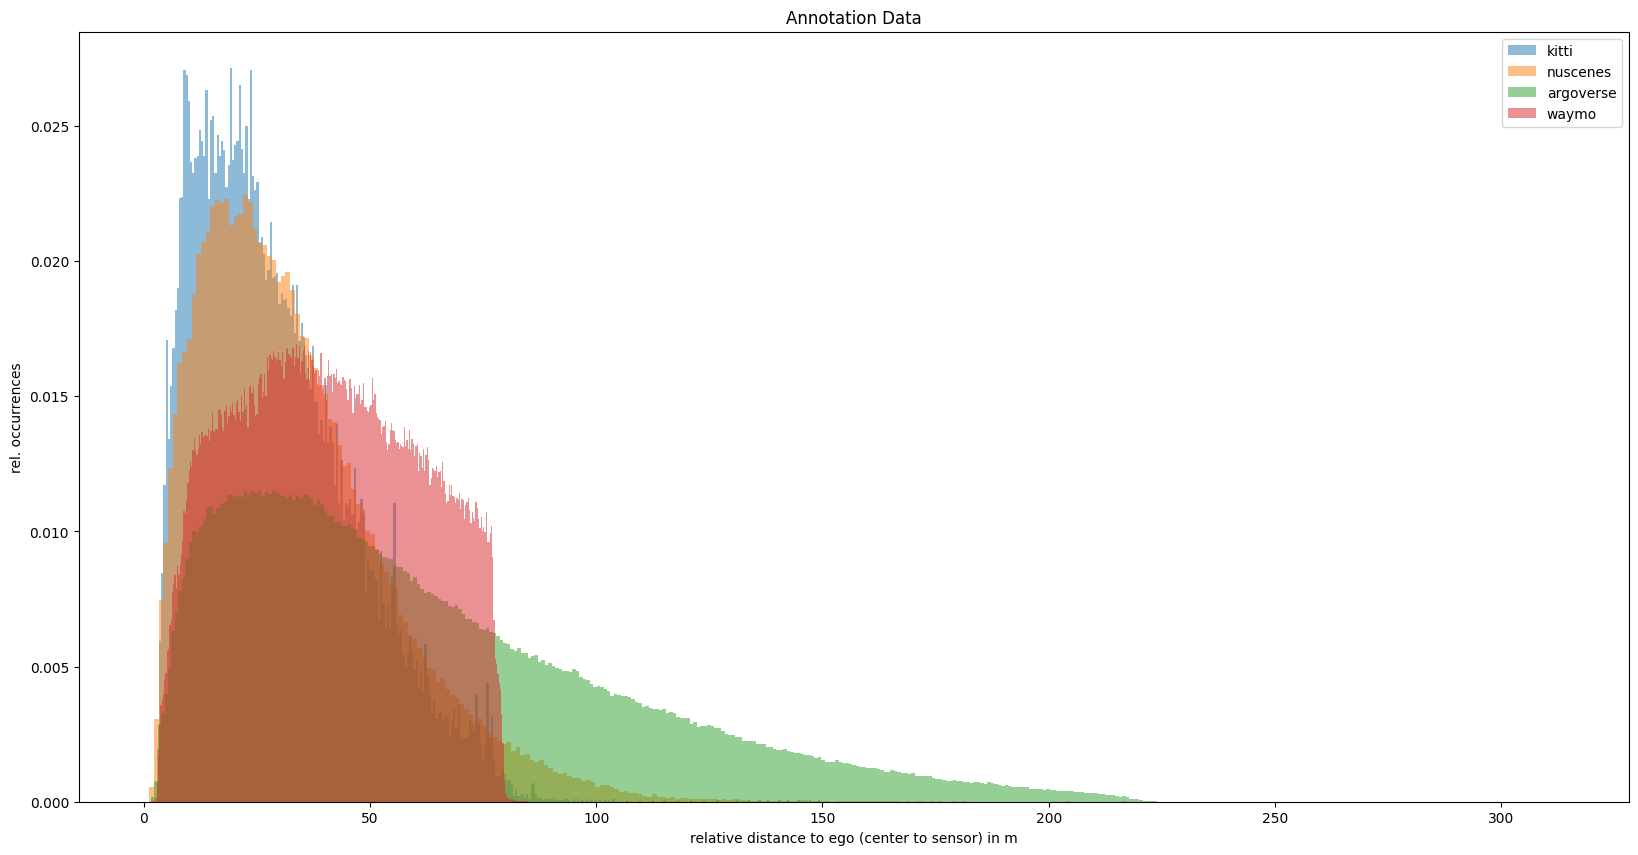

In [15]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.set_title("Annotation Data")
plt.xlabel("relative distance to ego (center to sensor) in m")
plt.ylabel("rel. occurrences")
plt.hist(kitti_distances, bins=300, alpha=0.5, label="kitti", density=True)
plt.hist(nuscenes_distances, bins=300, alpha=0.5, label="nuscenes", density=True)
plt.hist(argoverse_distances, bins=300, alpha=0.5, label="argoverse", density=True)
plt.hist(distances_waymo, bins=300, alpha=0.5, label="waymo", density=True)
plt.legend(loc="upper right")
plt.savefig("label_distribution.png")